### Load PC_diagnosis from BQ

In [1]:
# example: read from BigQuery chart to numpy
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
import numpy as np
import pandas as pd



client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
query = "select * from `som-nero-phi-jonc101.Clinical_Collaborative_Filtering.pc_dx`"; # Example dataset table


# to DataFrame

df_all = (
    client.query(query)
    .result()
    .to_dataframe()
)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


### Remove unnecessary columns and rows

In [2]:
print(df_all.head())

# only take PC_enc and proc_id
df = df_all[['PC_enc', 'PC_diagnosis']]

# remove duplicate rows:
df = df.drop_duplicates()

print(df.head())

     jc_uid        PC_enc     PC_app_datetime     PC_ref_datetime  \
0  JCcb6607  131239705939 2017-11-28 09:15:00 2017-11-28 10:21:00   
1  JCcb6607  131239705939 2017-11-28 09:15:00 2017-11-28 10:21:00   
2  JCcb6607  131239705939 2017-11-28 09:15:00 2017-11-28 10:21:00   
3  JCcb6607  131239705939 2017-11-28 09:15:00 2017-11-28 10:21:00   
4  JCcb6607  131239705939 2017-11-28 09:15:00 2017-11-28 10:21:00   

                                        PC_diagnosis  PC_dx_id        SP_enc  \
0                                    History of PCOS   1165431  131240863187   
1  Personal history of other diseases of the fema...   1368364  131240863187   
2                                      Acne vulgaris   1294300  131240863187   
3                                      Acne vulgaris   1294300  131240863187   
4  Personal history of other diseases of the fema...   1368364  131240863187   

      SP_app_datetime  
0 2018-03-17 09:00:00  
1 2018-03-17 09:00:00  
2 2018-03-17 09:00:00  
3 2018-0

(58176, 2)


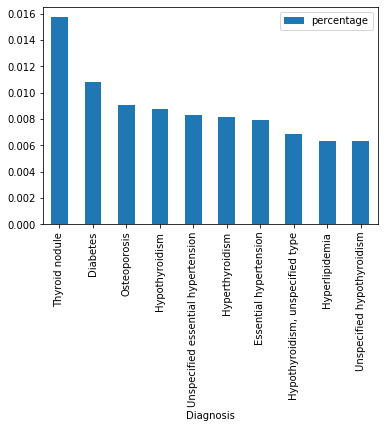

In [6]:
print(df.shape)
lendf = df.shape[0]
df_plot = df['PC_diagnosis'].value_counts().head(10).reset_index().rename(columns={'index':'Diagnosis','PC_diagnosis':'percentage' })
df_plot['percentage' ]=df_plot['percentage' ]/lendf
df_plot.loc[1,'Diagnosis'] = 'Diabetes'
df_plot.plot.bar(x='Diagnosis',y='percentage' )
#print()

### Create the table of unique encounter id

In [8]:
unq_PC_enc = df.groupby(['PC_enc']).apply(len).reset_index().rename(columns={'PC_diagnosis':'PC_diagnosis', 0:'num_unq_proc'}).sort_values('num_unq_proc',ascending=False)  
print(len(unq_PC_enc))
print(unq_PC_enc.head())
print('All of the encounters with at least one diagnosis: ',len(unq_PC_enc))
print('Average diagnosis per encounter: ', np.mean(unq_PC_enc.num_unq_proc.to_numpy()))
print('Min # diagnosis per encounter: ', np.min(unq_PC_enc.num_unq_proc.to_numpy()))
print('Max # diagnosis per encounter: ', np.max(unq_PC_enc.num_unq_proc.to_numpy()))

12067
            PC_enc  num_unq_proc
1907  131016267790           177
4387  131038807665           107
5002  131064987703           105
5357  131082127660           104
2491  131020018602            98
All of the encounters with at least one diagnosis:  12067
Average diagnosis per encounter:  4.82108229054446
Min # diagnosis per encounter:  1
Max # diagnosis per encounter:  177


### Sort according to the most frequent labs (not necessarily how important they are)

In [9]:


Top_proc = [ ['iabetes'] # diabetes mellitus, Type II or unspecified type diabetes mellitus, Prediabetes
            , ['ypercalcemia', 'hyperparathyroidism'] # Hypercalcemia
            , ['yperlipidemia'] #hyperlipidemia
            , ['ypothyroidism'] #hypothyroidism
            , ['yperthyroidism', 'hyrotoxicosis' ] #hyperthyroidism or Thyrotoxicosis
            , ['Obesity']
            , ['steopenia'] #(Osteopenia)
            , ['steoporosis'] #Osteoporosis
            , ['cancer', 'alignant','carcinoma']# Thyroid cancer (CMS-HCC) ## or 'gland', or 'carcinoma'
            , ['nodul'] # Thyroid nodule or ''goiter' #Nontoxic uninodular goiter,  Nontoxic multinodular goiter'
            ######
            #, 'itamin'# Vitamin D deficiency (Vitamin D insufficiency)
           ]

N_diagnosis = len(Top_proc)
print(N_diagnosis)
#print(Top_proc)

#df=df.sort_values('num',ascending=False)

10


### Create Feature Matrix of Lab Results

In [10]:
print(df.columns)
import sys

for i in range(N_diagnosis):
    
    # define the function: applies on the lab results of each encounter
    def my_func(df):
        L = Top_proc[i]
        s = 0
        for j in range(len(L)):
            s = s + len(df[df.PC_diagnosis.str.contains(L[j])])
        return int(s>0)

        #return int(len(df.query('SP_diagnosis.str.contains("iabetes")'))>0)
    
    F_df = df.groupby(['PC_enc']).apply(my_func).reset_index().rename(columns={'PC_diagnosis':'PC_diagnosis', 0:'F'+str(i)}) 
    unq_PC_enc = pd.merge(unq_PC_enc, F_df, how='left', on='PC_enc')
    
    # report i 
    sys.stdout.write('\r')
    sys.stdout.write(str(i/N_diagnosis*100)+'%')
    sys.stdout.flush()


print(unq_PC_enc.head())


Index(['PC_enc', 'PC_diagnosis'], dtype='object')
90.0%         PC_enc  num_unq_proc  F0  F1  F2  F3  F4  F5  F6  F7  F8  F9
0  131016267790           177   1   1   1   1   0   0   0   0   0   0
1  131038807665           107   0   0   0   0   0   0   0   0   0   0
2  131064987703           105   1   0   0   0   0   0   0   0   0   0
3  131082127660           104   0   0   0   0   0   0   0   0   0   0
4  131020018602            98   1   0   0   1   0   1   0   0   0   0


### Save the Results into CSV

In [11]:
print(len(unq_PC_enc)) 
#print(unq_PC_enc.sort_values('F0',ascending=False))
#print(np.sum(unq_PC_enc['F0'].to_numpy()))
unq_PC_enc.to_csv('PC_diagnosis.csv', index=False)

12067


### Do some analysis 

In [12]:
print('Number of patient with each of the diagnosis')
for i in range(15):
    print(np.sum(unq_PC_enc['F'+str(i)].to_numpy()))

#F0: 3612
#F1: 1650

Number of patient with each of the diagnosis
2918
208
993
1319
636
274
306
933
1969
1398


KeyError: 'F10'

In [5]:
A = [['abbsda'], ['bdsad' ,'cff']]
print(len(A[1]))

2
